<a href="https://colab.research.google.com/github/Keshav-Sundar-4/RD_ML_Model/blob/main/Jacobian_reaction_diffusion_textures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Differentiable Programming of Reaction-Diffusion Patterns" supplementary code

* [Project page](https://selforglive.github.io/alife_rd_textures/)
* [Paper](https://selforglive.github.io/alife_rd_textures/ALIFE_Reaction_Diffusion.pdf)




In [ ]:
!pip install --upgrade pysindy
print(ps.__version__)


1.7.5


In [11]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
#import sympy as sp
import multiprocessing
#import pysindy as ps

from tqdm import tnrange

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

"""
def imread(path, max_size=None, mode=None):
    # Open the image from the local path
    img = PIL.Image.open(path)

    # Resize the image if max_size is provided
    if max_size is not None:
        img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)

    # Convert the image mode if needed
    if mode is not None:
        img = img.convert(mode)

    # Convert to a NumPy array with float32 values scaled to [0, 1]
    img = np.float32(img) / 255.0

    return img
"""

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_tmp.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_tmp.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(kw.get('fade_len', 1.0)*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-40d9e80b-b379-3c8a-8b15-a592df2ce0fc)


In [2]:
!wget https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/targets.zip && unzip targets.zip

--2024-10-01 14:20:19--  https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/targets.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-research/self-organising-systems/master/assets/reaction_diffusion_textures/targets.zip [following]
--2024-10-01 14:20:20--  https://raw.githubusercontent.com/google-research/self-organising-systems/master/assets/reaction_diffusion_textures/targets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63479 (62K) [application/zip]
Saving to: ‘targets.zip’

targets.zip         100%[===================>]  6

In [2]:
#!wget https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/zebra_target.jpg
!wget https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/turing_pattern_target.jpg

--2024-10-01 14:30:11--  https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/turing_pattern_target.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99883 (98K) [image/jpeg]
Saving to: ‘turing_pattern_target.jpg’

turing_pattern_targ 100%[===================>]  97.54K  --.-KB/s    in 0.01s   

2024-10-01 14:30:12 (6.50 MB/s) - ‘turing_pattern_target.jpg’ saved [99883/99883]



  from scipy.ndimage.filters import gaussian_filter



Parameter count: 2176
Seed state examples:


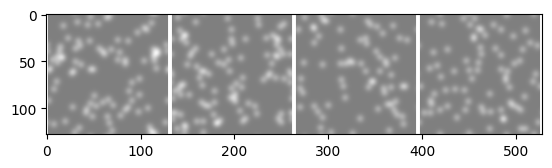

In [3]:
#@title Reaction Diffusion Model {vertical-output: true}

from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import imshow

# Number of grid "chemical" channels
CHN = 8

def seed_f(n, sz=96, spot_prob=0.005, spread=3.0):
    '''Create seed states with scattered gaussian blobs'''
    x = tf.floor(tf.random.uniform([n, sz, sz, 1]) + spot_prob)
    x = gaussian_filter(x, [0.0, spread, spread, 0.0], mode='wrap')
    x = x * spread**2
    x = tf.repeat(x, 3, -1)
    x = tf.pad(x, [(0, 0), (0, 0), (0, 0), (0, CHN - x.shape[-1])])
    return x.numpy()

def pad_repeat(x, pad=1):
    x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
    x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
    return x

def to_rgb(x):
    return x[..., :3] + 0.5

@tf.function
def laplacian(x):
    lap = np.float32([[1, 2, 1], [2, 4-16, 2], [1, 2, 1]]) / 16.0
    kernel = tf.repeat(lap[:, :, None, None], x.shape[-1], 2)
    x = pad_repeat(x, 1)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'VALID')
    return y

class CA(tf.keras.Model):
    def __init__(self):
        super(CA, self).__init__()
        self.w1 = Conv2D(128, 1)
        self.w2 = Conv2D(CHN, 1, use_bias=False, kernel_initializer=tf.zeros)
        self.diff_coef = tf.repeat([0.125, 0.25, 0.5, 1.0], CHN//4)
        self(tf.constant(seed_f(1)))

    def get_diff_coef(self):
        return self.diff_coef

    @tf.function
    def __call__(self, x, r=1.0, d=1.0):
      diff = laplacian(x)*self.get_diff_coef()
      y = self.w1(x)
      y = y*tf.nn.sigmoid(y*5.0)
      react = self.w2(y)
      x = x + diff*d + react*r
      return x

ca = CA()
param_n = np.sum([np.prod(v.shape) for v in ca.trainable_variables])
print('Parameter count:', param_n)
print('Seed state examples:')
img = to_rgb(seed_f(4, 128))
img = np.pad(img, [(0, 0), (0, 0), (2, 2), (0, 0)], constant_values=1.0)
imshow(np.hstack(img))


# RD model training

In [4]:
#@title VGG16 texture model
STYLE_LAYERS = ['block%d_conv1'%i for i in range(1, 6)]
CONTENT_LAYER = 'block4_conv2'

class StyleModel:
  def __init__(self):
        vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
        vgg.trainable = False
        for layer in vgg.layers:
            layer.trainable = False
        layers = STYLE_LAYERS + [CONTENT_LAYER]
        layers = {name: vgg.get_layer(name).output for name in layers}
        self.model = tf.keras.Model([vgg.input], layers)
        self.model.trainable = False  # Ensure the model is not trainable
        for layer in self.model.layers:
            layer.trainable = False

  def run_model(self, img):
        img = img[..., ::-1]*255.0 - np.float32([103.939, 116.779, 123.68])
        layers = self.model(img, training=False)  # Set training=False
        style = [layers[name] for name in STYLE_LAYERS]
        return style, layers[CONTENT_LAYER]


  def calc_style_content(self, img):
    style_layers, content = self.run_model(img)
    style = [gram_style(a) for a in style_layers]
    return style, content

def gram_style(a):
  n, h, w, ch = tf.unstack(tf.shape(a))
  a = tf.sqrt(a+1.0)-1.0
  gram = tf.einsum('bhwc, bhwd -> bcd', a, a)
  return gram / tf.cast(h*w, tf.float32)

@tf.function
def style_loss(a, b): # reduce_mean
  return tf.add_n([tf.reduce_mean(tf.square(x-y), [-2, -1]) for x, y in zip(a, b)])


style_model = StyleModel()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#@title Inception model

inception_pb = 'gs://modelzoo/vision/other_models/InceptionV1.pb'

class Inception:
  def __init__(self):
    with tf.io.gfile.GFile(inception_pb, 'rb') as f:
      self.graph_def = tf.compat.v1.GraphDef.FromString(f.read())
    avgpool0_idx = [n.name for n in self.graph_def.node].index('avgpool0')
    del self.graph_def.node[avgpool0_idx:]
    del self.graph_def.node[0]  # placeholder
    # use pre_relu layers for Concat nodes
    self.outputs = []
    for node in self.graph_def.node:
      if 'Concat' in node.op:
        self.outputs.append(node.name+':0')
        self.outputs += [inp+'_pre_relu:0' for inp in node.input[1:]]

  @tf.function(experimental_compile=True)
  def __call__(self, x):
    imgs = x*255.0-117.0
    outputs = tf.import_graph_def(self.graph_def, {'input':imgs}, self.outputs)
    outputs = dict(zip(self.outputs, outputs))
    layers = {}
    for node in self.graph_def.node:
      if 'Concat' in node.op:
        layers[node.name] = outputs[node.name+':0']
        pre_relus = [outputs[inp+'_pre_relu:0'] for inp in node.input[1:]]
        layers[node.name+'_pre_relu'] = tf.concat(pre_relus, -1)
    return layers

model = Inception()
model_name = 'inception'

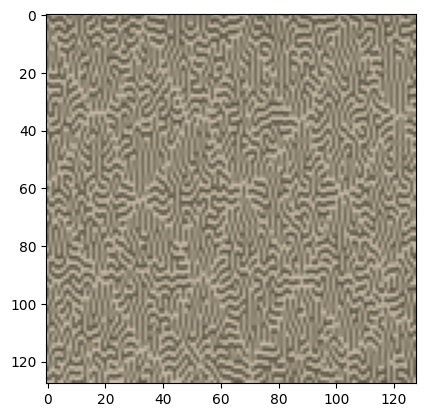

In [5]:
from skimage.transform import resize

model_name = 'turing_pattern'
style_img = imread('%s_target.jpg'%model_name)

# Get the height and width of the image
height, width, _ = style_img.shape

# Resize the image to 128x128
style_img = resize(style_img, (128, 128), anti_aliasing=True)

#style_img = imread('zebra_target.jpg')
imshow(style_img)


# RD system is fully isotropic, so we use a variant of texture loss that
# tries to match input image with rotated versions of the target sample
target_styles = []
for r in np.linspace(0.0, 360, 65)[:-1]+0.12345:
  img = ndimage.rotate(style_img, r, reshape=False, mode='wrap')
  style, _ = style_model.calc_style_content(img[None,...])
  target_styles.append(style)
imwrite('%s.jpg'%model_name, style_img)

In [6]:
#@title Setup training
ca = CA()
loss_log = []

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 10000], [1e-3, 2e-4, 5e-5])
trainer = tf.optimizers.Adam(lr)

@tf.function
def style_loss_f(x):
  imgs = to_rgb(x)
  gs, content = style_model.calc_style_content(imgs)
  sl = np.inf
  for ts in target_styles:
    sl = tf.minimum(sl, style_loss(gs, ts))
  return tf.reduce_mean(sl)

# *BONUS* Inception-V1 feature visualisztion loss may produce
# interesting patterns for some channels (esp. for those
# that correspond to isotropic textures)
@tf.function
def inception_loss_f(x):
  imgs = to_rgb(x)
  clip_imgs = tf.clip_by_value(imgs, 0.0, 1.0)
  overflow_loss = tf.reduce_mean(tf.square(clip_imgs-imgs))
  tensor = model(clip_imgs)['mixed4a_pre_relu']
  loss = -tf.reduce_mean(tensor[...,461])
  return loss + overflow_loss*10.0

pool = seed_f(1024)

@tf.function
def train_step(x):
  with tf.GradientTape() as g:
    step_n = tf.random.uniform([], 32, 128, tf.int32)
    for i in tf.range(step_n):
      x = ca(x)
    loss = style_loss_f(x)
  params = ca.trainable_variables
  grads = g.gradient(loss, params)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, params))
  return loss, x

In [7]:
#@title Numeric Jacobian Approach

def compute_reaction_jacobian(x_cell, model):
    x_cell = tf.reshape(tf.convert_to_tensor(x_cell, dtype=tf.float32), (1, 1, 1, -1))  # Shape: (1, 1, 1, 32)

    with tf.GradientTape() as tape:
        tape.watch(x_cell)
        reaction_output = model(x_cell)  # Shape: (1, 1, 1, 32)

    jacobian = tape.batch_jacobian(reaction_output, x_cell)  # Shape: (1, 1, 1, 32, 32)
    jacobian = jacobian.numpy().squeeze()  # Shape: (32, 32)
    return jacobian


def compute_diffusion_jacobian(c_i, delta_h):
    laplacian_coefficient = -4.0 / (delta_h ** 2)
    J_diffusion = np.diag(c_i * laplacian_coefficient)  # Shape: (32, 32)
    return J_diffusion


def compute_total_jacobian(x_cell, model, c_i, delta_h):
    J_reaction = compute_reaction_jacobian(x_cell, model)
    J_diffusion = compute_diffusion_jacobian(c_i, delta_h)
    J_total = J_reaction + J_diffusion  # Shape: (32, 32)
    return J_total

"""
# Usage
grid = ca(seed_f(1, sz=96))  # Forward pass through the trained model
x_cell = grid[0, 96//2, 96//2, :]  # Extract central grid cell values
c_i = ca.diff_coef.numpy()  # Assuming 'ca' is your trained model
delta_h = 1.0             # Spatial step size

# Ensure your model is in evaluation mode if necessary
ca.trainable = False

J_total = compute_total_jacobian(x_cell, ca, c_i, delta_h)
print("Jacobian Matrix shape:", J_total.shape)
print("Jacobian Matrix:", J_total)
"""


'\n# Usage\ngrid = ca(seed_f(1, sz=96))  # Forward pass through the trained model\nx_cell = grid[0, 96//2, 96//2, :]  # Extract central grid cell values\nc_i = ca.diff_coef.numpy()  # Assuming \'ca\' is your trained model\ndelta_h = 1.0             # Spatial step size\n\n# Ensure your model is in evaluation mode if necessary\nca.trainable = False\n\nJ_total = compute_total_jacobian(x_cell, ca, c_i, delta_h)\nprint("Jacobian Matrix shape:", J_total.shape)\nprint("Jacobian Matrix:", J_total)\n'

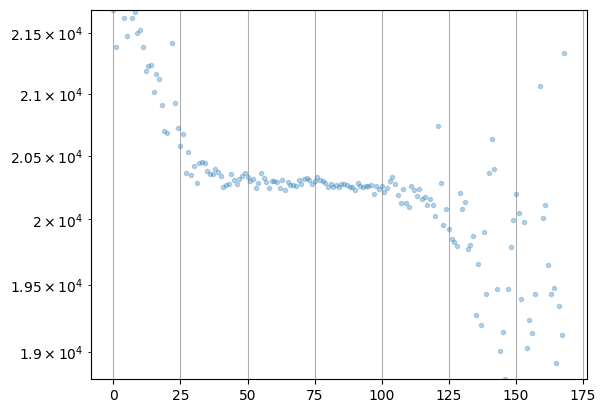

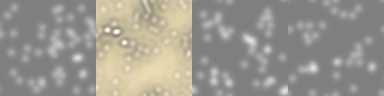

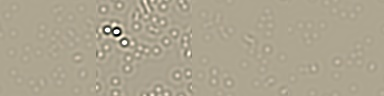

 169 21332.668

KeyboardInterrupt: 

In [13]:
#@title Training loop {vertical-output: true}

# Initialize storage for Jacobian changes
jacobian_changes = []
previous_jacobian = None
sampling_interval = 100  # Adjust based on how frequently you want to sample (e.g., every 100 iterations)

# Extract diffusion coefficients from the CA model
c_i_example = ca.get_diff_coef().numpy()  # Shape: (CHN,)

for i in range(20000):
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x0 = pool[batch_idx].copy()  # Use .copy() to avoid modifying the original pool

    if i % 32 == 0:   # Periodically inject seed states in the batch every 32 iterations
        x0[:1] = seed_f(1)

    h, w = x0.shape[1:-1]
    loss, x = train_step(x0)
    pool[batch_idx] = x.numpy()  # Update the pool with the new states
    loss_log.append(loss.numpy())

    # --- Jacobian Change Tracking ---
    if i % sampling_interval == 0 and i != 0:
        # Select a representative cell (e.g., central cell of the first image in the batch)
        sz = x.shape[1]
        central_cell = x[0, sz // 2, sz // 2, :].numpy()

        # Compute current Jacobian using the existing compute_total_jacobian function
        J_current = compute_total_jacobian(central_cell, ca, c_i_example, delta_h=1.0)

        if previous_jacobian is not None:
            # Compute change in Jacobian
            delta_J = J_current - previous_jacobian
            jacobian_changes.append(delta_J)

        # Update previous Jacobian for the next iteration
        previous_jacobian = J_current.copy()

    # --- Visualization and Logging Every 16 Iterations ---
    if i % 16 == 0:
        clear_output(wait=True)
        pl.plot(loss_log, '.', alpha=0.3)
        if np.min(loss_log) > 0.0:
            pl.yscale('log')
        pl.ylim(np.min(loss_log), loss_log[0])
        pl.grid()
        pl.show()
        imshow(np.hstack(to_rgb(x0)))
        imshow(np.hstack(to_rgb(x)))
        print('\r', len(loss_log), loss.numpy(), end='')

    # --- Save Model Variables Every 1000 Loss Updates ---
    if len(loss_log) % 1000 == 0:
        np.save('%s_%05d.npy' % (model_name, len(loss_log)),
                [v.numpy() for v in ca.variables])

In [1]:
#@title "Jacobian" PDE

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

CHN = jacobian_changes.shape[1]  # Number of chemicals

# Initialize a dictionary to store fitted models for each J_ij
fitted_models = {}

# Prepare the feature matrix (flattened Jacobians)
X = jacobian_changes.reshape(jacobian_changes.shape[0], -1)  # Shape: (num_samples, CHN*CHN)

# Define the polynomial degree
poly_degree = 2  # Up to cubic terms

poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_poly = poly.fit_transform(X)  # Shape: (num_samples, features)

# Iterate over each J_ij to fit a separate model
for i in range(CHN):
    for j in range(CHN):
        # Target variable: change in J_ij
        Y = jacobian_changes[:, i, j]

        # Fit linear regression model with polynomial features
        model = LinearRegression()
        model.fit(X_poly, Y)

        # Store the model and the transformer
        fitted_models[(i, j)] = model

def simulate_pde_system(seed_state, fitted_models, c_i, delta_h=1.0, delta_t=0.01, steps=1000):
    """
    Simulates the RD system using the derived PDE system based on Jacobian changes.

    Parameters:
    - seed_state (np.ndarray): Initial grid state (1, sz, sz, CHN).
    - fitted_models (dict): Fitted models for each J_ij.
    - c_i (np.ndarray): Diffusion coefficients (CHN,).
    - delta_h (float): Spatial step size.
    - delta_t (float): Time step size.
    - steps (int): Number of simulation steps.

    Returns:
    - grid (np.ndarray): Final grid state after simulation.
    """
    grid = seed_state.copy()
    sz = grid.shape[1]
    CHN = grid.shape[-1]

    # Initialize Jacobian matrix
    central_cell = grid[0, sz//2, sz//2, :].copy()
    J = compute_total_jacobian(central_cell, ca, c_i, delta_h=1.0)

    for step in range(steps):
        new_J = J.copy()
        # Flatten current Jacobian for prediction
        J_flat = J.flatten().reshape(1, -1)
        # Transform features
        poly = PolynomialFeatures(degree=3, include_bias=False)
        J_poly = poly.fit_transform(J_flat)

        # Update each J_ij
        for i in range(CHN):
            for j in range(CHN):
                model = fitted_models[(i, j)]
                delta_J_ij = model.predict(J_poly)[0]
                new_J[i, j] += delta_J_ij * delta_t

        # Update chemical concentrations based on new_J
        new_grid = grid.copy()
        for i in range(sz):
            for j in range(sz):
                x = grid[0, i, j, :].copy()
                # Reaction term
                reaction = new_J @ x
                # Diffusion term
                x_tensor = tf.convert_to_tensor(x.reshape(1, 1, 1, -1), dtype=tf.float32)
                diffusion = laplacian(x_tensor).numpy().reshape(-1) * c_i
                # Update concentrations
                dx_dt = reaction + diffusion
                new_x = x + dx_dt * delta_t
                # Clip to maintain valid concentrations
                new_x = np.clip(new_x, 0, 1)
                new_grid[0, i, j, :] = new_x

        # Update grid and Jacobian for next step
        grid = new_grid
        J = new_J

        if step % 200 == 0:
            print(f"Simulation Step {step} completed.")

    return grid

# Run the simulation
final_grid_simulated = simulate_pde_system(
    seed_state=seed_state.numpy(),
    fitted_models=fitted_models,
    c_i=c_i_example,
    delta_h=1.0,
    delta_t=0.01,
    steps=1000
)

# Convert to RGB and visualize
final_rgb_simulated = to_rgb(final_grid_simulated[0].astype(np.float32))
final_rgb_simulated = np.clip(final_rgb_simulated, 0, 1)
imshow(final_rgb_simulated)
plt.title("Final Recreated Pattern Using Derived PDEs")
plt.axis('off')
plt.show()

NameError: name 'np' is not defined

Jacobian Matrix shape: (8, 8)
Jacobian Matrix: [[ 5.10733366e-01  8.78628343e-02  8.42890143e-02  5.79896718e-02
   1.36769488e-01  8.87708217e-02 -1.41051248e-01 -1.01770177e-01]
 [ 1.59968019e-01  4.59296644e-01  3.91399935e-02  4.60857116e-02
   1.52265161e-01  6.54306337e-02 -1.04518689e-01 -8.11168328e-02]
 [ 1.61702633e-01  2.03294724e-01 -1.03144050e-02  6.21539056e-02
   1.86397135e-01  7.48977959e-02 -1.77920222e-01 -1.25704676e-01]
 [ 1.57393545e-01  8.60491097e-02  2.47695260e-02 -1.21574163e-01
   2.18754321e-01 -2.76649906e-03 -3.27541605e-02 -1.05171129e-01]
 [ 2.57505596e-01  1.21013381e-01  2.92556405e-01  3.52073640e-01
  -1.26563072e+00  1.98287830e-01 -3.38433176e-01 -5.88231325e-01]
 [ 1.86948240e-01  8.68055373e-02  2.74760664e-01  6.33329749e-02
   7.80699104e-02 -1.01187921e+00 -6.10642284e-02 -2.52033114e-01]
 [ 2.09810987e-01  1.44505307e-01  2.16824248e-01  1.23891560e-02
   3.54949564e-01  9.67192799e-02 -3.23257279e+00 -1.19521804e-01]
 [ 2.12605596e-01  2.0

In [ ]:
#@title Combined Reaction-Diffusion PDE Formulation

def compute_reaction_jacobian(x_cell, model):
    """
    Computes the reaction Jacobian for a single grid cell.

    Parameters:
    - x_cell (np.ndarray): The concentration vector of shape (CHN,).
    - model (CA): The trained CA model.

    Returns:
    - J_reaction (np.ndarray): The reaction Jacobian matrix of shape (CHN, CHN).
    """
    x_cell_tf = tf.reshape(tf.convert_to_tensor(x_cell, dtype=tf.float32), (1, 1, 1, -1))  # Shape: (1, 1, 1, CHN)

    with tf.GradientTape() as tape:
        tape.watch(x_cell_tf)
        reaction_output = model(x_cell_tf)  # Shape: (1, 1, 1, CHN)

    jacobian = tape.batch_jacobian(reaction_output, x_cell_tf)  # Shape: (1, 1, 1, CHN, CHN)
    jacobian = jacobian.numpy().squeeze()  # Shape: (CHN, CHN)
    return jacobian

def compute_diffusion_jacobian(c_i, delta_h=1.0):
    """
    Computes the diffusion Jacobian matrix.

    Parameters:
    - c_i (np.ndarray): Diffusion coefficients for each chemical, shape (CHN,).
    - delta_h (float): Spatial step size.

    Returns:
    - J_diffusion (np.ndarray): The diffusion Jacobian matrix, shape (CHN, CHN).
    """
    laplacian_coefficient = -4.0 / (delta_h ** 2)
    J_diffusion = np.diag(c_i * laplacian_coefficient)  # Shape: (CHN, CHN)
    return J_diffusion

def formulate_pde(J_reaction, c_i, delta_h=1.0, threshold=1e-2):
    """
    Combines the reaction and diffusion Jacobians and filters out negligible reaction terms.

    Parameters:
    - J_reaction (np.ndarray): Reaction Jacobian matrix, shape (CHN, CHN).
    - c_i (np.ndarray): Diffusion coefficients, shape (CHN,).
    - delta_h (float): Spatial step size.
    - threshold (float): Threshold below which reaction terms are considered negligible.

    Returns:
    - J_total (np.ndarray): Combined Jacobian matrix, shape (CHN, CHN).
    """
    # Step 1: Filter out small reaction terms
    J_reaction_filtered = J_reaction.copy()
    J_reaction_filtered[np.abs(J_reaction_filtered) < threshold] = 0.0

    # Step 2: Compute diffusion Jacobian
    J_diffusion = compute_diffusion_jacobian(c_i, delta_h)

    # Step 3: Combine reaction and diffusion Jacobians
    J_total = J_reaction_filtered + J_diffusion

    return J_total

def print_pde(J_total):
    """
    Prints the governing PDEs in a readable format.

    Parameters:
    - J_total (np.ndarray): Combined Jacobian matrix, shape (CHN, CHN).
    """
    CHN = J_total.shape[0]
    print("\nGoverning PDEs:")
    for i in range(CHN):
        terms = []
        for j in range(CHN):
            coef = J_total[i, j]
            if coef != 0.0:
                # Determine the sign
                sign = "+" if coef >= 0 else "-"
                coef_abs = abs(coef)
                # Format coefficient: omit 1 and -1 for simplicity
                if coef_abs == 1.0:
                    term = f"{sign} x_{j+1}"
                else:
                    term = f"{sign} {coef_abs:.4f} * x_{j+1}"
                terms.append(term)
        # Combine terms, ensuring the first term has the correct sign
        if terms:
            pde = " ".join(terms).replace("+ -", "- ")
            # Remove leading '+' if present
            if pde.startswith('+ '):
                pde = pde[2:]
        else:
            pde = "0"
        print(f"dx_{i+1}/dt = {pde}")




In [ ]:
#@title Jacobian Approach PDE Output
# Example Usage: Compute and Print the Governing PDEs

# Step 1: Forward pass through the trained model to get the grid
# Note: Ensure the model is in inference mode
ca.trainable = False  # Set the model to non-trainable

# Generate a grid by applying the model multiple times (optional)
# For Jacobian computation, we need a specific grid state; let's use one iteration
grid = ca(tf.constant(seed_f(1, sz=96)))  # Shape: (1, 96, 96, CHN)

# Step 2: Extract the state of a specific grid cell
# For this example, we'll use the central cell
sz = grid.shape[1]
central_cell = grid[0, sz//2, sz//2, :].numpy()  # Shape: (CHN,)

# Step 3: Get the diffusion coefficients
c_i = ca.get_diff_coef().numpy()  # Shape: (CHN,)

# Step 4: Define spatial step size
delta_h = 1.0  # As per your model

# Step 5: Compute the total Jacobian
J_total = compute_total_jacobian(central_cell, ca, c_i, delta_h)

# Step 6: Filter out negligible terms
threshold = 1e-2
J_filtered = formulate_pde(J_total, threshold)

# Step 7: Print the governing PDEs
print_pde(J_filtered)


In [ ]:
#@title Jacobian Time Step Simulation (For confirmation)
def simulate_pde(J_total, x_initial, delta_t=0.01, steps=1000, output_interval=200):
    """
    Simulates the RD system using the combined Jacobian over a specified number of time steps.

    Parameters:
    - J_total (np.ndarray): Combined Jacobian matrix (CHN x CHN).
    - x_initial (np.ndarray): Initial concentrations (CHN,).
    - delta_t (float): Time step size.
    - steps (int): Number of simulation steps.
    - output_interval (int): Interval at which to output RGB images.

    Returns:
    - None
    """
    x = x_initial.copy()
    images = []

    for step in range(steps):
        # Update concentrations using the Jacobian
        dx_dt = J_total @ x
        x += dx_dt * delta_t

        # Optional: Normalize or clip concentrations if necessary
        x = np.clip(x, 0, 1)

        # Output RGB images at specified intervals
        if step % output_interval == 0:
            # Extract the first three chemicals for RGB
            rgb = x[:3] + 0.5  # Adjust based on your to_rgb function
            rgb = np.clip(rgb, 0, 1)  # Ensure values are within [0, 1]
            images.append(rgb)
            print(f"Step {step}: RGB = {rgb}")

    # Display the collected RGB images
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img_rgb, step in zip(axs, images, range(0, steps, output_interval)):
        ax.imshow(np.ones((10, 10, 3)) * img_rgb, aspect='auto')  # Create a solid color image
        ax.set_title(f"Step {step}")
        ax.axis('off')
    plt.show()

# Step 1: Define the initial state (e.g., the central cell's state)
x_initial = central_cell.copy()  # Shape: (CHN,)

# Step 2: Define simulation parameters
delta_t = 0.01  # Time step size
steps = 1000     # Total number of steps
output_interval = 200  # Interval to output RGB images

# Step 3: Run the simulation
simulate_pde(J_filtered, x_initial, delta_t, steps, output_interval)


In [ ]:
#@title SINDY PDE Extractor
# Define parameters
num_steps = 1000      # Number of time steps to simulate
grid_size = 128       # Size of the 2D grid (grid_size x grid_size)
CHN = 4               # Number of chemicals

# Initialize data array to store concentrations over time
# Shape: (num_steps, grid_size, grid_size, CHN)
data = np.zeros((num_steps, grid_size, grid_size, CHN), dtype=np.float32)

# Initialize the CA model with a seed state
# Assuming 'ca' and 'seed_f' are predefined and trained elsewhere

# Seed the initial state
x = tf.constant(seed_f(1, sz=grid_size))  # Shape: [1, grid_size, grid_size, CHN]

# Simulate the CA model and collect data
print("Starting simulation...")
for step in range(num_steps):
    x = ca(x)
    data[step] = x.numpy()
    if (step + 1) % 100 == 0:
        print(f"Completed step {step + 1}/{num_steps}")
print("Simulation complete.")

# Compute Laplacians using scipy's laplace function for consistency
# Note: scipy's laplace assumes scalar fields, so we apply it per chemical
laplacians = np.zeros_like(data)
for i in range(CHN):
    # Apply laplace to each grid cell for chemical i
    laplacians[:, :, :, i] = ndimage.laplace(data[:, :, :, i], mode='wrap')

# Compute temporal derivatives using central differences
# Initialize dCdt with the same shape as data
dCdt = np.zeros_like(data)

# Compute central differences for interior points
dCdt[1:-1] = (data[2:] - data[:-2]) / 2.0

# Forward difference for the first time step
dCdt[0] = data[1] - data[0]

# Backward difference for the last time step
dCdt[-1] = data[-1] - data[-2]

# Reshape data for SINDy
# New shape: (num_steps * grid_size * grid_size, CHN)
samples = num_steps * grid_size * grid_size
X = data.reshape(samples, CHN)  # Concentrations

# Reaction terms: dCdt - diffusion
diff_coeffs = ca.get_diff_coef().numpy().reshape(1, 1, 1, CHN)  # Assuming get_diff_coef() exists
R = dCdt - (diff_coeffs * laplacians)  # Reaction terms
R = R.reshape(samples, CHN)            # Flattened reaction terms

# Initialize SINDy models for each chemical
# We'll use a polynomial library up to degree 2 and STLSQ optimizer for sparsity
feature_library = ps.PolynomialLibrary(degree=2, include_bias=True)
optimizer = ps.STLSQ(threshold=0.1)  # Adjust threshold as needed

# Create a list of SINDy models, one for each chemical
models = [
    ps.SINDy(
        feature_library=feature_library,
        optimizer=optimizer
    ) for _ in range(CHN)
]

# Fit SINDy models for each chemical
print("Fitting SINDy models...")
for i in range(CHN):
    print(f"\nFitting model for chemical c{i}...")

    # Extract target reaction term for chemical c_i
    y = R[:, i].reshape(-1, 1)  # Shape: (samples, 1)

    # Fit the SINDy model
    models[i].fit(X, t=None, x_dot=y, quiet=True)  # Set quiet=False for verbose output

    # Instead of using models[i].print(), extract the equation manually
    print(f"\nDiscovered equation for chemical c{i}':")

    # Access the discovered equation from the equations_ attribute
    if hasattr(models[i], 'equations_') and len(models[i].equations_) > 0:
        discovered_eq = models[i].equations_[0]
        print(discovered_eq)
    else:
        print("No equation discovered.")

print("\nSINDy fitting complete.")

# Extract simplified reaction terms from SINDy models
def extract_sindy_equations(models, CHN):
    """
    Extracts and formats the simplified equations from SINDy models.

    Parameters:
    - models: List of fitted SINDy models.
    - CHN: Number of chemicals.

    Returns:
    - List of simplified reaction equations as strings.
    """
    simplified_equations = []
    for i in range(CHN):
        # Check if an equation was discovered
        if hasattr(models[i], 'equations_') and len(models[i].equations_) > 0:
            equation_str = models[i].equations_[0]
        else:
            equation_str = "0"
        simplified_equations.append(equation_str)
    return simplified_equations

# Extract simplified reaction equations
simplified_reactions = extract_sindy_equations(models, CHN)

# Display the simplified PDEs with correct labels
print("\nSimplified PDEs using SINDy:")
for i, eq in enumerate(simplified_reactions):
    diffusion_coefficient = diff_coeffs[0, 0, 0, i]
    print(f"\nPDE for chemical c{i}:")
    print(f"dc{i}/dt = {diffusion_coefficient:.4f}*Laplace(c{i}) + {eq}")


Starting simulation...
Completed step 100/1000
Completed step 200/1000
Completed step 300/1000
Completed step 400/1000
Completed step 500/1000
Completed step 600/1000
Completed step 700/1000
Completed step 800/1000
Completed step 900/1000
Completed step 1000/1000
Simulation complete.
Fitting SINDy models...

Fitting model for chemical c0...

Discovered equation for chemical c0':
No equation discovered.

Fitting model for chemical c1...

Discovered equation for chemical c1':
No equation discovered.

Fitting model for chemical c2...

Discovered equation for chemical c2':
No equation discovered.

Fitting model for chemical c3...


KeyboardInterrupt: 

In [ ]:
#@title Neural Network PDE Extractor with Limited Terms

# Extract weights and biases from the model
W1 = ca.w1.get_weights()[0]  # Shape: [1, 1, CHN, 128]
b1 = ca.w1.get_weights()[1]  # Shape: [128]
W2 = ca.w2.get_weights()[0]  # Shape: [1, 1, 128, CHN]

# Reshape weights for easier manipulation
W1 = W1.reshape(CHN, 128)    # Shape: [CHN, 128]
W2 = W2.reshape(128, CHN)    # Shape: [128, CHN]

# Reshaping is necessary because, for a single grid cell, a convolution with a kernel size of 1x1 acts like a fully connected layer.

# Define symbolic variables for the chemical concentrations
c_symbols = sp.symbols(f'c0:{CHN}')  # c0, c1, ..., c{CHN-1}
c_vec = sp.Matrix(c_symbols).reshape(CHN, 1)  # Shape: [CHN, 1]

# Convert numpy arrays to sympy matrices
W1_sym = sp.Matrix(W1)  # Shape: [CHN, 128]
b1_sym = sp.Matrix(b1).reshape(128, 1)  # Shape: [128, 1]

# Compute z = W1^T * c + b1
z = W1_sym.T * c_vec + b1_sym  # Shape: [128, 1]

# Define the activation function y = z * sigmoid(5 * z)
def activation(z_vec):
    y_elements = []
    for z_i in z_vec:
        sigmoid = 1 / (1 + sp.exp(-5 * z_i))
        y_i = z_i * sigmoid
        y_elements.append(y_i)
    y_vec = sp.Matrix(y_elements)
    return y_vec

# Compute y
y = activation(z)  # Shape: [128, 1]

# Convert W2 to a sympy matrix
W2_sym = sp.Matrix(W2)  # Shape: [128, CHN]

# Compute reaction term R = W2^T * y
R = W2_sym.T * y  # Shape: [CHN, 1]

# Define symbols for time derivatives and Laplacians
t = sp.symbols('t')
dc_dt_symbols = [sp.Function(f'c{i}')(t).diff(t) for i in range(CHN)]
laplacian_symbols = sp.symbols(f'L0:{CHN}')  # L0, L1, ..., L{CHN-1}

# Get diffusion coefficients
D = ca.diff_coef.numpy()  # Shape: [CHN]

# Construct PDEs
pdes = []
for i in range(CHN):
    # Left-hand side: dc_i/dt
    lhs = dc_dt_symbols[i]
    # Right-hand side: D_i * Laplacian(c_i) + R_i(c)
    diffusion_term = D[i] * laplacian_symbols[i]
    reaction_term = R[i]
    # PDE: dc_i/dt = D_i * Laplacian(c_i) + R_i(c)
    pde = sp.Eq(lhs, diffusion_term + reaction_term)
    pdes.append(pde)

# Function to simplify a single PDE while preserving the top 'x' linear and non-linear terms
def simplify_pde_with_top_terms(pde, variables, top_x=10, threshold=1e-3):
    """
    Simplifies a SymPy PDE by retaining the top 'x' most significant linear and non-linear terms.

    Parameters:
    - pde: SymPy Eq object representing the PDE.
    - variables: List of SymPy symbols to collect terms upon.
    - top_x: Integer, number of top linear and non-linear terms to retain.
    - threshold: Float, minimum coefficient magnitude to consider a term significant.

    Returns:
    - simplified_pde: Simplified SymPy Eq object.
    """
    # Extract RHS of the PDE
    rhs = pde.rhs.expand()

    # Initialize lists for linear and non-linear terms
    linear_terms = []
    nonlinear_terms = []

    # Decompose RHS into individual terms
    if isinstance(rhs, sp.Add):
        terms = rhs.args
    else:
        terms = [rhs]

    # Categorize terms
    for term in terms:
        coeff, expr = term.as_coeff_Mul()
        # Check if term is non-linear
        if expr.is_Mul or expr.is_Pow or expr.func in [sp.sin, sp.cos, sp.exp, sp.log]:
            nonlinear_terms.append(term)
        else:
            linear_terms.append(term)

    # Sort linear terms by absolute coefficient value
    linear_terms_sorted = sorted(linear_terms, key=lambda x: abs(x.as_coeff_Mul()[0]), reverse=True)
    # Sort non-linear terms by absolute coefficient value
    nonlinear_terms_sorted = sorted(nonlinear_terms, key=lambda x: abs(x.as_coeff_Mul()[0]), reverse=True)

    # Select top 'x' linear and non-linear terms
    top_linear = [term for term in linear_terms_sorted if abs(term.as_coeff_Mul()[0]) >= threshold][:top_x]
    top_nonlinear = [term for term in nonlinear_terms_sorted][:top_x]

    # Combine the selected terms
    selected_terms = top_linear + top_nonlinear

    # Sum the selected terms
    new_rhs = sum(selected_terms) if selected_terms else 0

    # Collect like terms for better readability
    collected_rhs = sp.collect(new_rhs, variables)

    # Final simplification
    final_rhs = sp.simplify(collected_rhs)

    # Reconstruct the simplified PDE
    simplified_pde = sp.Eq(pde.lhs, final_rhs)

    return simplified_pde

# Function to simplify all PDEs with top 'x' terms
def simplify_all_pdes_with_top_terms(pdes_list, variables, top_x=10, threshold=1e-3):
    """
    Simplifies a list of SymPy PDE equations by retaining the top 'x' linear and non-linear terms.

    Parameters:
    - pdes_list: List of SymPy Eq objects representing the PDEs.
    - variables: List of SymPy symbols to collect terms upon.
    - top_x: Integer, number of top linear and non-linear terms to retain.
    - threshold: Float, minimum coefficient magnitude to consider a term significant.

    Returns:
    - simplified_pdes: List of simplified SymPy Eq objects.
    """
    simplified_pdes = []
    for pde in pdes_list:
        simplified_pde = simplify_pde_with_top_terms(pde, variables, top_x, threshold)
        simplified_pdes.append(simplified_pde)
    return simplified_pdes

# Define the variables to collect upon
variables = c_symbols  # List of c0, c1, c2, c3

# Simplify all PDEs retaining top 'x' terms
top_x = 10  # Adjust 'x' as needed
simplified_pdes = simplify_all_pdes_with_top_terms(pdes, variables, top_x=top_x, threshold=1e-3)

# Function to print simplified PDEs neatly
def print_simplified_pdes(simplified_pdes_list):
    for i, pde in enumerate(simplified_pdes_list):
        print(f"\nSimplified PDE for chemical c{i}:")
        sp.pprint(pde)

# Print the simplified PDEs
print_simplified_pdes(simplified_pdes)


In [ ]:
#@title Model behavior video {vertical-output: true}
with VideoWriter() as vid:
  x = seed_f(1, 256)
  for i in tqdm.tnrange(30*8):
    step_n = min(int(2**(i/30.0)), 200)
    for _ in range(step_n):
      x = ca(x, r=0.5)
    frame = to_rgb(x)[0]
    vid.add(zoom(frame, 2))


# Experiments with pretrained models

In [ ]:
!wget https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/rd_tex_models.zip

In [ ]:
models = np.load('rd_tex_models.zip', allow_pickle=True)
names = ['banded_0037_20000', 'lined_0118_15000', 'polka-dotted_0121_20000',
         'grid_0135_20000', 'interlaced_0172_20000', 'chequered_0121_20000',
         'lizard_20000']

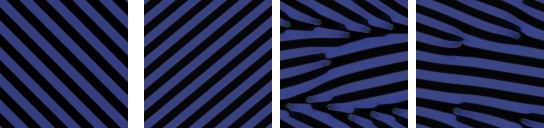

banded_0037


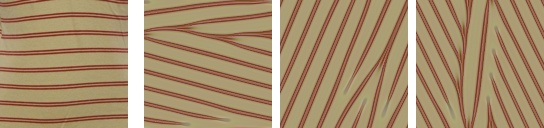

lined_0118


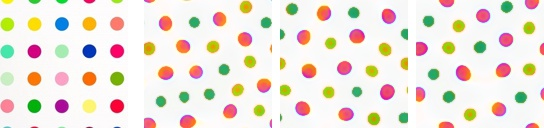

polka-dotted_0121


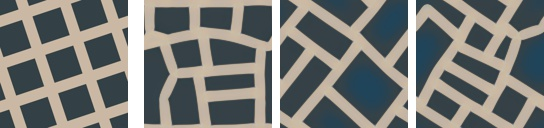

grid_0135


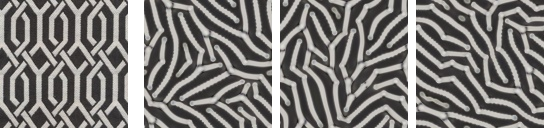

interlaced_0172


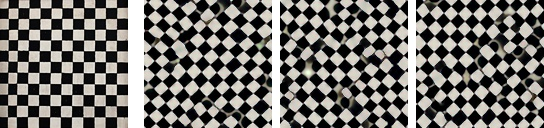

chequered_0121


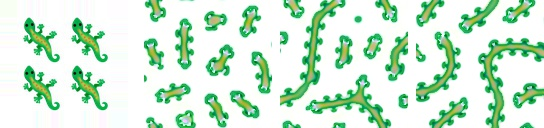

lizard


In [ ]:
#@title Figure 2 {vertical-output: true}
#@markdown RD-generated patterns (videos are stored as "\<model_name\>.mp4")
ca = CA()
rows = []
for name in names:
  src = name.rsplit('_', 1)[0]+'_target.jpg'
  src = imread(src)
  ph, pw = (128-np.int32(src.shape[:2]))//2
  src = np.pad(src, [(ph, ph), (pw, pw), (0, 0)], 'edge')
  [v.assign(p) for p, v in zip(models[name], ca.variables)]
  x = seed_f(3, 128)
  with VideoWriter(name+'.mp4') as vid:
    for i in tnrange(30*10):
      step_n = min(2**(i//30), 128)
      for i in range(step_n):
        x = ca(x)
      img = to_rgb(x)
      img = np.pad(img, [(0, 0), (0, 0), (8, 0), (0, 0)], constant_values=1.0)
      img = np.hstack(img)
      img = np.hstack([src, np.ones([128, 8, 3]), img])
      vid.add(zoom(img, 2))
  imshow(img)
  print(name[:-6])

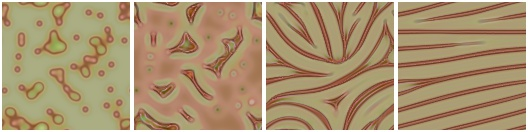

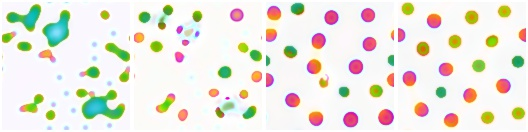

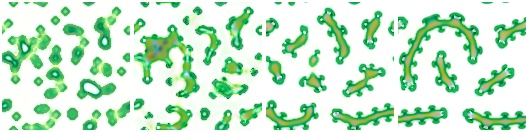

In [ ]:
#@title Figure 3: grid states at steps 50, 1e2, 1e3, 1e4 {vertical-output: true}
ca = CA()
rows = []
for name in 'lined_0118_15000 polka-dotted_0121_20000 lizard_20000'.split():
  [v.assign(p) for p, v in zip(models[name], ca.variables)]
  x = seed_f(1, 128)
  imgs = []
  for i in range(10000):
    x = ca(x)
    if (i+1) in [50, 100, 1000, 10000]:
      img = to_rgb(x)[0]
      img = np.pad(img, [(2, 2), (2, 2), (0, 0)], constant_values=1.0)
      imgs.append(img)
  row = np.hstack(imgs)
  rows.append(row)
  imshow(row)
imwrite('rows.jpg', np.vstack(rows))

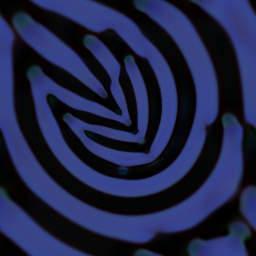

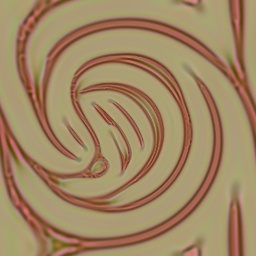

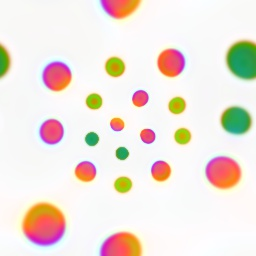

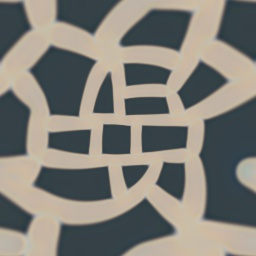

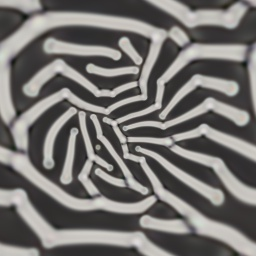

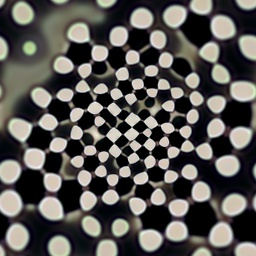

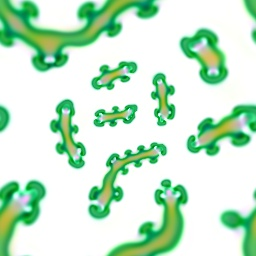

In [ ]:
#@title Figure 4: non-unifirm diffusion speed {vertical-output: true}
y, x = np.ogrid[-2:2:256j,-2:2:256j]
s = 3**-2
r = s+np.exp(-x*x-y*y)*(1.0-s)
r = np.float32(r[:,:,None])

ca = CA()
for name in names:
  [v.assign(p) for p, v in zip(models[name], ca.variables)]
  x = seed_f(1, 256)
  for i in tnrange(10000, leave=False):
    x = ca(x, r=r)
  imshow(to_rgb(x)[0])

In [ ]:
#@title Figure 4 (non-unifirm diffusion speed video) {vertical-output: true}
y, x = np.ogrid[-2:2:256j,-2:2:256j]
s = 3**-2
r = s+np.exp(-x*x-y*y)*(1.0-s)
r = np.float32(r[:,:,None])

ca = CA()
[v.assign(p) for p, v in zip(models['grid_0135_20000'], ca.variables)]

with LoopWriter('loop.mp4') as vid:
  x = seed_f(1, 256)
  for i in tnrange(30*10, leave=False):
    step_n = min(int(2**(i/30.0)), 200)
    for _ in range(step_n):
      x = ca(x, r=r)
    img = tf.image.resize(to_rgb(x)[0], [512, 512], tf.image.ResizeMethod.BICUBIC)
    vid.add(img)
vid.show(loop=True)

# Mesh and Volume generalization

In [ ]:
!pip install trimesh vispy
import vispy
vispy.use(app='egl')

In [ ]:
!wget http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz && tar -xzf bunny.tar.gz

In [ ]:
import trimesh
mesh = trimesh.load('bunny/reconstruction/bun_zipper.ply')
mesh.vertices -= mesh.vertices.mean(0, keepdims=True)
mesh.vertices /= mesh.vertices.ptp()
lap = trimesh.smoothing.laplacian_calculation(mesh, False)
lap = tf.sparse.SparseTensor(np.c_[lap.row, lap.col],
                           np.float32(lap.data), lap.shape)

In [ ]:
#@title mesh 3d render
from vispy import gloo, app

vertex = """
    uniform float aspect;
    uniform mat4 T;
    attribute vec3 position;
    attribute vec3 normal;
    attribute vec3 color;
    varying vec3 v_color;
    varying vec3 v_normal;
    void main()
    {
      v_color = color;
      v_normal = (T*vec4(normal, 1.0)).rgb;
      vec4 p = T*vec4(position, 1.0);
      float zoom = 1.4;
      gl_Position = vec4(zoom*p.x,
                         zoom*p.y*aspect,
                         -p.z, 1.0-p.z*0.2);
    } """

fragment = """
    varying vec3 v_color;
    varying vec3 v_normal;
    void main() {
      vec3 n = normalize(v_normal);
      gl_FragColor = vec4(v_color*n.z, 1.0);
    } """

class Canvas(app.Canvas):
    def __init__(self, mesh):
        super().__init__(size=(800, 600))

        self.indices = gloo.IndexBuffer(np.uint32(mesh.faces))
        self.program = gloo.Program(vertex, fragment)
        self.program['position'] = np.float32(mesh.vertices.copy())
        self.program['normal'] = np.float32(mesh.vertex_normals.copy())
        w, h = self.size
        self.program['aspect'] = w/h

    def on_draw(self, event):
      gloo.set_state('opaque')
      gloo.set_clear_color('white')
      gloo.clear()
      self.program.draw('triangles', self.indices)

    def render_mesh(self, color, T=np.eye(4)):
      self.program['color'] = color
      self.program['T'] = T
      return self.render()[..., :3]

renderer = Canvas(mesh)

In [ ]:
names

['banded_0037_20000',
 'lined_0118_15000',
 'polka-dotted_0121_20000',
 'grid_0135_20000',
 'interlaced_0172_20000',
 'chequered_0121_20000',
 'lizard_20000']

In [ ]:
#@title Figure 5: RD model on a mesh {vertical-output: true}
ca = CA()
name = 'lizard_20000'
[v.assign(p) for p, v in zip(models[name], ca.variables)]

@tf.function
def step_f(ca, x, r=0.8, d=0.5):
  w1 = ca.w1.kernel[0, 0]
  b1 = ca.w1.bias
  w2 = ca.w2.kernel[0, 0]
  lx = tf.sparse.sparse_dense_matmul(lap, x)-x
  diff = lx*ca.get_giff_coef()
  y = x@w1+b1
  y = y*tf.nn.sigmoid(y*5.0)
  react = y@w2
  x = x + diff*d + react*r
  return x

x = np.floor(np.random.rand(len(mesh.vertices), 1)+0.005).astype(np.float32)
for i in range(8):
  x = tf.sparse.sparse_dense_matmul(lap, x)
x *= 6.0
x = np.float32(x*(np.arange(CHN)<3))

fps = 60.0
dur = 10
with VideoWriter('mesh_%s.mp4'%name, fps=fps) as vid:
  for i in tnrange(int(fps*dur)):
    step_n = int(min(2**(i/fps), 30))
    for _ in range(step_n):
      x = step_f(ca, x)
    rgb = to_rgb(x).numpy()
    t = i/(fps*dur)
    t = t*t*(3.0-2.0*t)
    T = trimesh.transformations.rotation_matrix(2*np.pi*t, [0.0, 0.8, 0.2])
    img = renderer.render_mesh(rgb, T)
    vid.add(img)
imwrite('mesh_%s.jpg'%name, img)
vid.show()

In [ ]:
#@title volume renderer code
import vispy.geometry
from vispy import gloo, app

vertex = """
    #version 130
    uniform float aspect;
    uniform float head;
    uniform float pitch;
    in vec3 position;
    out vec3 ray_start;
    out vec3 ray_dir;

    mat2 rot(float a) {
      float c=cos(a), s=sin(a);
      return mat2(c, -s, s, c);
    }
    vec3 tform(vec3 p) {
      p.yz = rot(-pitch)*p.yz;
      p.xz = rot(-head)*p.xz;
      return p;
    }
    void main() {
      ray_start = tform(vec3(0.0, 0.0, -1.8))+0.5;
      ray_dir = tform(vec3(position.xy*vec2(aspect, 1.0), 1.0));
      gl_Position = vec4(position*2.0, 1.0);
    } """

fragment = """
    #version 130
    uniform sampler3D vol;
    uniform vec3 sliceMin;
    uniform vec3 sliceMax;
    in vec3 ray_start;
    in vec3 ray_dir;
    const float dt = 0.005;

    vec2 intersect_box(vec3 orig, vec3 dir) {
      vec3 inv_dir = 1.0 / dir;
      vec3 tmin_tmp = (sliceMin - orig) * inv_dir;
      vec3 tmax_tmp = (sliceMax - orig) * inv_dir;
      vec3 tmin = min(tmin_tmp, tmax_tmp);
      vec3 tmax = max(tmin_tmp, tmax_tmp);
      float t0 = max(tmin.x, max(tmin.y, tmin.z));
      float t1 = min(tmax.x, min(tmax.y, tmax.z));
      return vec2(t0, t1);
    }

    void main() {
      vec3 p = ray_start;
      vec3 d = normalize(ray_dir);
      vec2 t_hit = intersect_box(p, d);
      if (t_hit.x > t_hit.y) {
        discard;
      }
      t_hit.x = max(t_hit.x, 0.0);
      vec4 acc = vec4(0.0);
      for (float t=t_hit.x; t<t_hit.y; t+=dt) {
        vec3 c = texture(vol, p+d*t).rgb;
        float a = 1.0-c.r*c.g*c.b;
        a = a*a;
        c *= a;
        float opacity = 70.0;
        acc.rgb += opacity*dt*c*(1.0-acc.a);
        acc.a += opacity*dt*a*(1.0-acc.a);
        if (acc.a >= 0.95) {
          break;
        }
      }
      gl_FragColor = acc;
    } """

class VolCanvas(app.Canvas):
    def __init__(self, vol):
        super().__init__(size=(600, 600))

        self.vol = gloo.Texture3D(vol,
          interpolation='linear', wrapping='repeat')

        verts, indices, _ = vispy.geometry.create_plane()
        self.indices = gloo.IndexBuffer(indices)
        self.program = gloo.Program(vertex, fragment)
        w, h = self.size
        self.program['aspect'] = w/h
        self.program['position'] = verts
        self.program['vol'] = self.vol
        self.program['sliceMin'] = [0.0, 0.0, 0.0]
        self.program['sliceMax'] = [1.0, 1.0, 1.0]

    def on_draw(self, event):
      gloo.set_state('translucent')
      gloo.set_clear_color('white')
      gloo.clear()
      self.program.draw('triangles', self.indices)

    def render_volume(self, head=0.5, pitch=0.5):
      self.program['head'] = head
      self.program['pitch'] = pitch
      return canvas.render()[...,:3]

In [ ]:
names

['banded_0037_20000',
 'lined_0118_15000',
 'polka-dotted_0121_20000',
 'grid_0135_20000',
 'interlaced_0172_20000',
 'chequered_0121_20000',
 'lizard_20000']

In [ ]:
#@title Figure 6: RD model in 3D volume {vertical-output: true}

ca = CA()
name = 'lizard_20000'
[v.assign(p) for p, v in zip(models[name], ca.variables)]

def pad_repeat3d(x, pad=1):
  x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
  x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
  x = tf.concat([x[:, :, :, -pad:], x, x[:, :, :, :pad]], 3)
  return x

@tf.function
def step_f(ca, x, r=0.8, d=0.6):
  w1 = ca.w1.kernel[0, 0]
  b1 = ca.w1.bias
  w2 = ca.w2.kernel[0, 0]
  lx = tf.nn.avg_pool3d(pad_repeat3d(x), 3, 1, 'VALID')-x
  diff = lx*ca.get_giff_coef()
  y = x@w1+b1
  y = y*tf.nn.sigmoid(y*5.0)
  react = y@w2
  x = x + diff*d + react*r
  return x

d = 100
x = np.float32(np.floor(np.random.rand(1, d, d, d, 1)+0.001))
for i in range(10):
  x = tf.nn.avg_pool3d(x, 3, 1, 'SAME')
x *= 30.0
x = np.float32(x*(np.arange(CHN)<3))
print(x.max())

canvas = VolCanvas(np.array(to_rgb(x[0])))
imshow(canvas.render_volume())

with VideoWriter('vol_%s.mp4'%name) as vid:
  for i, t in enumerate(tqdm.tqdm_notebook(np.linspace(0.0, 1.0, 400))):
    step_n = int(min(2**(i/30), 50))
    for _ in range(step_n):
      x = step_f(ca, x)
    t = t*t*(3.0-2.0*t)
    canvas.vol.set_data(to_rgb(x[0]).numpy())
    img = canvas.render_volume(head=2.0*np.pi*t+0.3)
    vid.add(img)
    if i%10==0:
      clear_output(True)
      imshow(img)
      print(i, 'steps per frame:', step_n)
  for t in tqdm.tqdm_notebook(np.linspace(0, 2.0*np.pi, 120)):
    t = (np.cos(t)*0.5+0.5)*0.99+0.01
    canvas.program['sliceMin'] = [0.0, 0.0, 1.0-t]
    vid.add(canvas.render_volume(head=0.3))
  clear_output(True)
imwrite('vol_%s.jpg'%name, canvas.render_volume(head=0.3))
vid.show()